# Day 4

In [1]:
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

print(platform.platform())

Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.35


utils.py 파일이 현재 노트북과 같은 폴더에 있다고 가정합니다.

In [3]:
from utils import 모델평가

## ~~보스턴 주택 가격~~

In [189]:
from packaging import version
from sklearn.utils import Bunch
from pathlib import Path

if version.parse(sklearn.__version__) < version.parse('1.2'):
    from sklearn.datasets import load_boston
else:
    print("sklearn 1.2 이상에서는 load_boston이 제거되었습니다.")
    print('사유: 주택 가격에 인종적 요소가 포함되어 있어 논란이 있음.')
    boston = Bunch()
    # 파일은 별도로 준비 (공유 폴더에서 복사)
    if Path('boston.csv').exists():
        boston.frame = pd.read_csv('boston.csv')
        print(boston.frame.sample(5).round(2))

sklearn 1.2 이상에서는 load_boston이 제거되었습니다.
사유: 주택 가격에 인종적 요소가 포함되어 있어 논란이 있음.
     Price  CRIM    ZN  INDUS  CHAS   NOX    RM   AGE   DIS  RAD    TAX  \
66    19.4  0.04  80.0   3.37   0.0  0.40  5.79  31.1  6.61  4.0  337.0   
74    24.1  0.08   0.0  12.83   0.0  0.44  6.27   6.0  4.25  5.0  398.0   
319   21.0  0.48   0.0   9.90   0.0  0.54  6.11  58.8  4.00  4.0  304.0   
253   42.8  0.37  22.0   5.86   0.0  0.43  8.26   8.4  8.91  7.0  330.0   
315   16.2  0.25   0.0   9.90   0.0  0.54  5.70  77.7  3.94  4.0  304.0   

     PTRATIO       B  LSTAT  
66      16.1  396.90  10.24  
74      18.7  394.92   6.78  
319     18.4  396.23  12.73  
253     19.1  396.90   3.54  
315     18.4  396.42  11.50  


## 캘리포니아 주택 가격

In [7]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
housing.frame.sample(5).round(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
8406,3.41,33.0,3.76,1.14,1309.0,5.24,33.94,-118.36,1.52
2908,2.88,44.0,5.39,1.03,667.0,2.22,35.37,-119.04,0.83
4020,4.80,37.0,5.84,1.13,911.0,2.81,34.18,-118.51,2.95
7383,1.16,39.0,3.78,1.07,1520.0,4.27,33.97,-118.25,1.09
12004,2.34,16.0,3.94,1.05,365.0,2.07,33.89,-117.56,1.92


In [ ]:
특성별_정상필터 = {}

for 특성명 in housing.data.columns:
    특성열 = housing.data[특성명]
    Q1, Q3 = np.percentile(특성열, [25, 75])
    IQR = Q3 - Q1
    이상치하한 = Q1 - 1.5 * IQR
    이상치상한 = Q3 + 1.5 * IQR
    # print(f'정상 범위: {이상치하한:.2f} ~ {이상치상한:.2f}')
    특성별_정상필터[특성명] = 특성열.between(이상치하한, 이상치상한)

# 정상 필터의 교집합(논리곱)
정상필터 = np.logical_and.reduce(list(특성별_정상필터.values()))
print(f'전체 관측치 수: {len(정상필터):,}, 정상 범위: {np.sum(정상필터):,}')
# 정상 범위의 데이터를 별도로 저장
housing.cleaned = housing.frame.copy()[정상필터]
housing.cleaned.describe().round(2)

전체 관측치 수: 20,640, 정상 범위: 16,842


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,16842.00,16842.00,16842.00,16842.00,16842.00,16842.00,16842.00,16842.00,16842.00
mean,3.71,29.68,5.17,1.05,1264.51,2.84,35.66,-119.63,2.02
std,1.48,12.26,1.05,0.07,625.74,0.63,2.13,1.99,1.07
min,0.54,1.00,2.03,0.87,5.00,1.16,32.54,-124.35,0.15
25%,2.58,20.00,4.43,1.00,808.00,2.42,33.94,-121.83,1.21
50%,3.53,30.00,5.15,1.04,1153.50,2.80,34.28,-118.57,1.81
75%,4.66,38.00,5.87,1.09,1626.00,3.23,37.73,-118.04,2.60
max,8.01,52.00,8.45,1.24,3132.00,4.56,41.95,-114.57,5.00


In [60]:
import joblib

# 처리된 결과를 파일로 저장
joblib.dump(housing, 'housing.joblib')
# 저장된 파일 읽기
housing = joblib.load('housing.joblib')
print(housing.keys())
print(housing.frame.shape, housing.cleaned.shape)

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR', 'cleaned'])
(20640, 9) (16842, 9)


## 특성 공학

수집된 데이터에 수학적 기법 등을 적용해 의미적인 변화를 주는 전처리

## 다항식 차원 확장

Q: 상호작용과 다항식 중 어떤 것이 더 영향이 큰가요?

A: 보통은 상호작용이 중요한 경우가 많습니다.

In [72]:
from sklearn.preprocessing import PolynomialFeatures

Xs = np.linspace(0, 1, 12).reshape(4, 3)
# 상호작용 특성만 생성
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(Xs)
print('원본 + 상호작용 특성')
print(poly.get_feature_names_out())

poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(Xs)
print('원본 + 다항식 + 상호작용 특성')
print(poly.get_feature_names_out())

원본 + 상호작용 특성
['x0' 'x1' 'x2' 'x0 x1' 'x0 x2' 'x1 x2']
원본 + 다항식 + 상호작용 특성
['x0' 'x1' 'x2' 'x0^2' 'x0 x1' 'x0 x2' 'x1^2' 'x1 x2' 'x2^2']


## 구간 분할

In [171]:
from sklearn.preprocessing import KBinsDiscretizer

구간수 = 4

Xs = pd.DataFrame(np.random.rand(12, 1))
Xs.columns = ['x1']
# 균등 구간 간격 분할
구간분할기 = KBinsDiscretizer(n_bins=구간수, encode='ordinal', strategy='uniform')
구간 = 구간분할기.fit_transform(Xs)
구간표_uniform = pd.DataFrame(구간.astype('int'), columns=['uniform'])
# 사분 범위 기준 분할
구간분할기 = KBinsDiscretizer(n_bins=구간수, encode='ordinal', strategy='quantile', quantile_method='linear')
구간 = 구간분할기.fit_transform(Xs)
구간표_quantile = pd.DataFrame(구간.astype('int'), columns=['quantile'])
# 원-핫 인코딩
구간분할기 = KBinsDiscretizer(n_bins=구간수, encode='onehot-dense', strategy='quantile', quantile_method='linear')
구간_원핫 = pd.DataFrame(구간분할기.fit_transform(Xs).astype('int'))

pd.concat([Xs, 구간표_uniform, 구간표_quantile, 구간_원핫], axis=1).sort_values('x1').round(2)

,x1,uniform,quantile,0,1,2,3
1,0.07,0,0,1,0,0,0
7,0.20,0,0,1,0,0,0
8,0.27,0,0,1,0,0,0
10,0.32,1,1,0,1,0,0
2,0.36,1,1,0,1,0,0
5,0.45,1,1,0,1,0,0
3,0.48,1,2,0,0,1,0
0,0.56,2,2,0,0,1,0
9,0.61,2,2,0,0,1,0
4,0.62,2,3,0,0,0,1


## 범주형 변수

범주형(categorical) 변수는 유형 중 하나의 값을 갖습니다. 연속형 변수와 구분됩니다.

In [ ]:
colors = pd.Series(['R', 'G', 'B'])
정수인코딩 = colors.map({'R': 0, 'G': 1, 'B': 2}) # 임의적
원핫행렬 = np.eye(3).astype('int')
원핫인코딩 = pd.DataFrame(원핫행렬[정수인코딩], columns=['R', 'G', 'B'])
frame = pd.DataFrame({'색상': colors, 'ordinal': 정수인코딩})
frame = pd.concat([frame, 원핫인코딩], axis=1)
frame

,색상,ordinal,R,G,B
0,R,0,1,0,0
1,G,1,0,1,0
2,B,2,0,0,1


In [179]:
from sklearn.preprocessing import KBinsDiscretizer

구간분할기 = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
위도경도 = housing.frame[['Longitude', 'Latitude']]
구간 = 구간분할기.fit_transform(위도경도)
pd.concat([위도경도, pd.DataFrame(구간.astype('int'), columns=['위도구간', '경도구간'])], axis=1)

,Longitude,Latitude,위도구간,경도구간
0,-122.23,37.88,0,2
1,-122.22,37.86,0,2
2,-122.24,37.85,0,2
3,-122.25,37.85,0,2
4,-122.25,37.85,0,2
...,...,...,...,...
20635,-121.09,39.48,1,2
20636,-121.21,39.49,1,2
20637,-121.22,39.43,1,2
20638,-121.32,39.43,1,2


In [187]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

scores = {}

knn = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsRegressor())
])
튜닝기 = GridSearchCV(knn, {
    'knn__n_neighbors': range(3, 11, 2),
    'knn__p': [1, 2]
})

scores['kNN'] = 모델평가(튜닝기, housing.data, housing.target, random_state=3)
print(f'knn 최적 설정:\n{pd.Series(튜닝기.best_params_)}')

linreg = LinearRegression()
scores['linreg'] = 모델평가(linreg, housing.data, housing.target, random_state=3)

X2 = np.hstack([housing.data, housing.data**2])
scores['linreg_X2'] = 모델평가(linreg, X2, housing.target, random_state=3)

cleaned_data = housing.cleaned.drop(columns='MedHouseVal')
cleaned_target = housing.cleaned.MedHouseVal
scores['kNN_cleaned'] = 모델평가(
    튜닝기, cleaned_data, cleaned_target, random_state=3)
scores['linreg_cleaned'] = 모델평가(
    linreg, cleaned_data, cleaned_target, random_state=3)

X2_cleaned = np.hstack([cleaned_data, cleaned_data**2])
scores['linreg_X2_cleaned'] = 모델평가(
    linreg, X2_cleaned, cleaned_target, random_state=3)

X3_cleaned = np.hstack([cleaned_data, cleaned_data**2, cleaned_data**3])
scores['linreg_X3_cleaned'] = 모델평가(
    linreg, X3_cleaned, cleaned_target, random_state=3)

linreg_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('linreg', LinearRegression())
])
scores['linreg_poly_cleaned'] = 모델평가(
    linreg_poly, cleaned_data, cleaned_target, random_state=3)

# 지역 구간 정보 추가
구간분할기 = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
위도경도 = cleaned_data[['Longitude', 'Latitude']]
지역인코딩 = 구간분할기.fit_transform(위도경도)
data_plus_region = np.hstack([cleaned_data, 지역인코딩])

linreg_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('linreg', LinearRegression())
])
scores['linreg_poly_region'] = 모델평가(
    linreg_poly, data_plus_region, cleaned_target, random_state=3)

print(f'훈련된 특성수: {len(linreg_poly.named_steps["poly"].get_feature_names_out())}')
print(linreg_poly.named_steps['linreg'].coef_.shape)

pd.DataFrame(scores).round(3)

knn 최적 설정:
knn__n_neighbors    9
knn__p              1
dtype: int64
훈련된 특성수: 285
(285,)


,kNN,linreg,linreg_X2,kNN_cleaned,linreg_cleaned,linreg_X2_cleaned,linreg_X3_cleaned,linreg_poly_cleaned,linreg_poly_region
train,0.789,0.608,0.624,0.771,0.645,0.662,0.664,0.710,0.773
test,0.729,0.595,0.450,0.708,0.630,0.649,0.649,0.698,0.754


## 모델 표현력

성능은 데이터의 복잡도에 적절하게 대응하는 모델의 표현력이 중요합니다.

* 데이터 복잡도 > 모델 표현력: 과소적합
* 데이터 복잡도 < 모델 표현력: 과대적합

이상적으로는 모델의 표현력이 데이터 복잡도에 상응하는 것이 "적합(fit)"합니다.

b    -0.055
w1    1.087
dtype: float64
          x1       x3
train  0.820    0.892
new    0.649 -156.781
(12, 1)


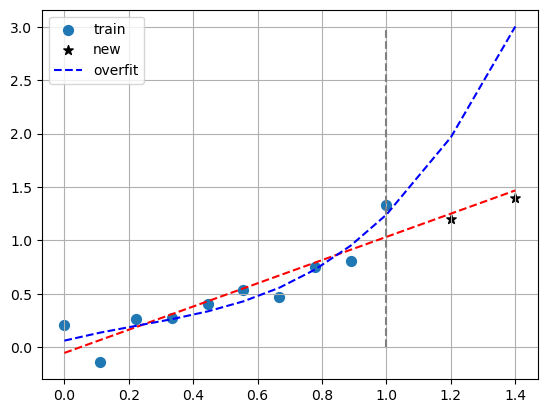

In [52]:
random = np.random.default_rng(3)
xs = np.linspace(0, 1, 10)
noise = random.normal(0, 0.1, xs.shape)
ys = xs + noise

scores = {}
model = LinearRegression()
data = xs.reshape(-1, 1); target = ys
model.fit(data, target)
print(pd.Series(np.append(model.intercept_, model.coef_), index=['b', 'w1']).round(3))
scores['x1'] = {'train': model.score(data, target)}

over_model = LinearRegression()
X3 = np.vstack([xs, xs**2, xs**3]).T
over_model.fit(X3, target)
scores['x3'] = {'train': over_model.score(X3, target)}

# 새로운 데이터 (테스트용)
x_new = np.array([1.2, 1.4]).reshape(-1, 1)
scores['x1']['new'] = model.score(x_new, x_new)

X3_new = np.hstack([x_new, x_new**2, x_new**3])
scores['x3']['new'] = over_model.score(X3_new, x_new)

print(pd.DataFrame(scores).round(3))

plt.scatter(xs, ys, s=50, label='train')
plt.scatter(x_new, x_new, s=50, marker='*', c='k', label='new')
all_data = np.vstack([data, x_new])
print(all_data.shape)
plt.plot(all_data, model.predict(all_data), 'r--')
# 모델이 기대하는 입력 형태로 변환
all_X3 = np.hstack([all_data, all_data**2, all_data**3])
plt.plot(all_data, over_model.predict(all_X3), 'b--', label='overfit')
# 훈련 데이터 경계선
plt.vlines(x=xs[-1], ymin=0.0, ymax=3.0, colors='gray', linestyles='--')
plt.grid()
plt.legend()
plt.show()

## 매장 매출 데이터

https://www.kaggle.com/competitions/store-sales-time-series-forecasting

In [ ]:
from pathlib import Path
from sklearn.utils import Bunch

sales = Bunch()
폴더 = Path('sales')
sales.train = pd.read_csv(
    폴더 / 'train.csv',
    index_col='date', # 날짜를 색인으로 지정
    # 날짜시간 문자열을 datetime 자료형으로 변환
    parse_dates=['date'], date_format='%Y-%m-%d')
print(sales.train.index.dtype) # datetime 자료형
sales.train.info()
# print(f'표본수: {len(sales.train):,}')
# sales.train.head()

datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [129]:
날짜문자열 = '01/02/03'

print(pd.to_datetime(날짜문자열, format='%m/%d/%y')) # 미국식
print(pd.to_datetime(날짜문자열, format='%d/%m/%y')) # 유럽식
print(pd.to_datetime(날짜문자열, format='%y/%m/%d')) # ISO 국제 표준

2003-01-02 00:00:00
2003-02-01 00:00:00
2001-02-03 00:00:00


In [131]:
sales.train_data = sales.train.drop(columns=['id'])
sales.train_data.sample(5)

,store_nbr,family,sales,onpromotion
date,,,,
2015-02-15,46,LINGERIE,11.0,0
2016-07-09,10,CLEANING,735.0,8
2016-11-10,17,LAWN AND GARDEN,0.0,0
2016-01-25,2,LAWN AND GARDEN,1.0,0
2015-05-17,53,GROCERY I,3263.0,6


In [132]:
sales.stores = pd.read_csv(폴더 / 'stores.csv')
sales.stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [163]:
from pathlib import Path
from sklearn.utils import Bunch

def 전처리(폴더):
    sales = Bunch()
    # 추가 정보
    sales.stores = pd.read_csv(폴더 / 'stores.csv')
    # 훈련/테스트 데이터
    for key in ['train', 'test']:
        sales[key] = pd.read_csv(
            폴더 / f'{key}.csv',
            index_col='date', # 날짜를 색인으로 지정
            # 날짜시간 문자열을 datetime 자료형으로 변환
            parse_dates=['date'], date_format='%Y-%m-%d')
        sales[key] = sales[key].drop(columns=['id'])
        # 매출 정보는 목표 변수이므로, 별도의 데이터로 분리
        if 'sales' in sales[key].columns:
            sales[f'{key}_target'] = sales[key].pop('sales')
        # 매장 번호(store_nbr)로 매장 정보 병합
        sales[f'{key}_data'] = pd.merge(sales[key], sales.stores, on='store_nbr', how='left')
        # 병합 후에도, 원래의 색인(날짜)을 유지
        sales[f'{key}_data'].index = sales[key].index
        # 정보를 병합하고 나면, 매장 번호는 제거
        sales[f'{key}_data'] = sales[f'{key}_data'].drop(columns=['store_nbr'])

    return sales

sales = 전처리(폴더)
# 파일로 저장
joblib.dump(sales, 'sales.joblib')
sales = joblib.load('sales.joblib')
print(sales.keys())
print(sales.train_data.shape, sales.test_data.shape)
sales.train_data.assign(sales=sales.train_target).sample(5)

dict_keys(['stores', 'train', 'train_target', 'train_data', 'test', 'test_data'])
(3000888, 6) (28512, 6)


,family,onpromotion,city,state,type,cluster,sales
date,,,,,,,
2013-01-21,HOME AND KITCHEN II,0,Guayaquil,Guayas,D,1,0.000
2015-07-24,POULTRY,39,Quito,Pichincha,A,5,1494.636
2015-02-27,GROCERY II,0,Quito,Pichincha,D,13,42.000
2015-06-11,GROCERY I,3,Riobamba,Chimborazo,C,7,2458.000
2015-10-17,"LIQUOR,WINE,BEER",0,Guayaquil,Guayas,B,6,56.000


In [150]:
sales.test_data.sample(5)

,family,onpromotion,city,state,type,cluster
date,,,,,,
2017-08-25,LAWN AND GARDEN,0,Cuenca,Azuay,D,2
2017-08-31,HOME CARE,1,Quito,Pichincha,D,8
2017-08-19,SCHOOL AND OFFICE SUPPLIES,10,Quito,Pichincha,B,16
2017-08-22,BEVERAGES,14,Ambato,Tungurahua,A,14
2017-08-24,PERSONAL CARE,7,El Carmen,Manabi,C,3


In [ ]:
제품군수 = sales.train_data['family'].nunique()
print(f'제품군 유형수: {제품군수}')
원핫행렬 = np.eye(제품군수)
print('원-핫 행렬 샘플')
제품군명 = sales.train_data['family'].unique()
pd.DataFrame(원핫행렬.astype('int'), columns=제품군명)[:3]

제품군 유형수: 33
원-핫 행렬 샘플


,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 결정트리

1980년대 신경망, 결정트리 등 현재 널리 활용되는 알고리즘들이 제시되었습니다.

In [190]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [193]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
iris.frame.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
46,5.1,3.8,1.6,0.2,0
102,7.1,3.0,5.9,2.1,2
51,6.4,3.2,4.5,1.5,1
58,6.6,2.9,4.6,1.3,1
89,5.5,2.5,4.0,1.3,1


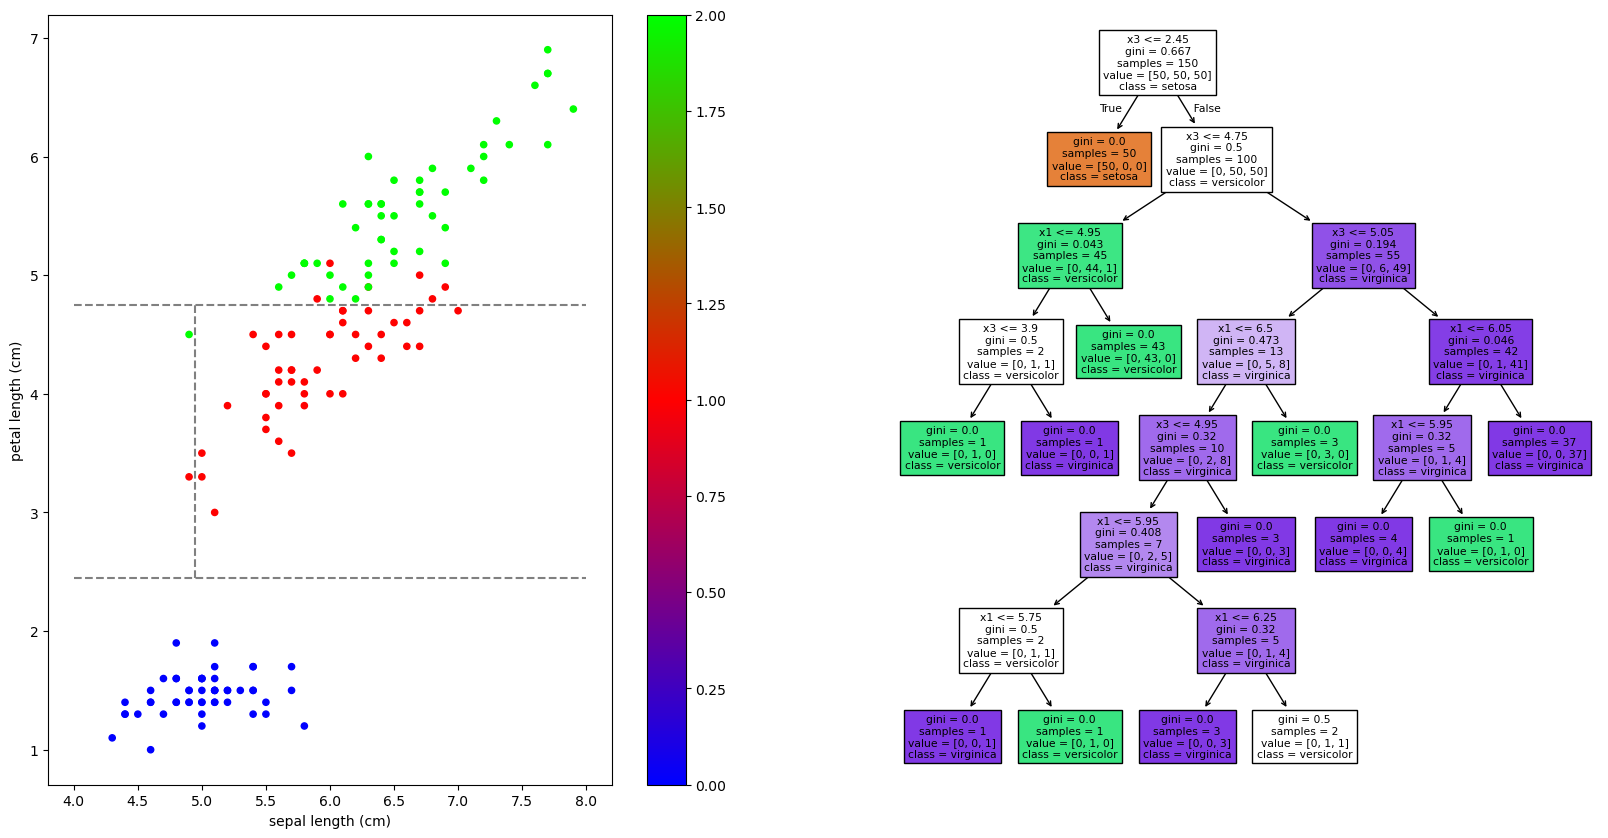

In [208]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

Xs = iris.data.iloc[:, [0, 2]] # x' = [x1, x3]
tree = DecisionTreeClassifier()
tree.fit(Xs, iris.target)

plt.figure(figsize=(20, 10))
왼쪽 = plt.subplot(1, 2, 1)
iris.frame.plot(kind='scatter', x=0, y=2, c=iris.target, cmap='brg', ax=왼쪽)
# 결정 경계
plt.hlines(y=[2.45, 4.75], xmin=4.0, xmax=8.0, colors='gray', linestyles='--')
plt.vlines(x=[4.95], ymin=2.45, ymax=4.75, colors='gray', linestyles='--')
오른쪽 = plt.subplot(1, 2, 2)
plot_tree(tree, ax=오른쪽, filled=True, feature_names=['x1', 'x3'], class_names=iris.target_names)
plt.show()